In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os
from vqe_utils import get_optimizer, excitation_ansatz, OPTIMIZERS

In [2]:
"""
Implementation of the noiseless VQE algorithm to find the ground state of dihydrogen (H₂) using both single and double excitations.

Multiple optimizers are used and compared.
"""

'\nImplementation of the noiseless VQE algorithm to find the ground state of dihydrogen (H₂) using both single and double excitations.\n\nMultiple optimizers are used and compared.\n'

In [3]:
# Define the atoms in the dihydrogen molecule
symbols = ["H", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.0000, 0.0000, 0.0000],  # Hydrogen 1
    [0.0000, 0.0000, 0.7414]   # Hydrogen 2
])

In [4]:
# Define the dihydrogen Hamiltonian and the number of qubits required
# Default STO-3G basis set
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0)

# 1 spatial orbital for each H
# Each spatial orbital is doubly-degenerate (2 spin orbitals)
print(f"{qubits} qubits required")

4 qubits required


In [5]:
# Which orbitals are occupied (1) or unoccupied (0) in the mean-field (Hartree-Fock) solution
electrons = 2  # 1 from each H
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

# Show that the first 2 orbitals are occupied
# Print the state in bra-ket notation
print(f"Hartree-Fock state: {'|' + ''.join(str(bit) for bit in hf) + '⟩'}")

Hartree-Fock state: |1100⟩


In [6]:
# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Create quantum device simulator backend
dev = qml.device("default.qubit",  # Noiseless state vector simulator
                 wires=num_wires)


@qml.qnode(dev)  # Transforms exp_energy below into a quantum node
def exp_energy(state):
    qml.BasisState(np.array(state), wires=range(num_wires))

    # Return the expectation value of the molecular Hamiltonian
    return qml.expval(hamiltonian)

# Calculate ⟨ψ_hf| hamiltonian |ψ_hf⟩ in Hartree (Ha) units
# 1 Ha = 27.2 eV
exp_energy(hf)

tensor(-0.88842304, requires_grad=True)

In [7]:
# Generate excitation indices
singles, doubles = excitations(electrons, qubits)
print(f"Singles Excitations: {singles}")  # e.g: [0, 1] is a single excitation of an electron in orbital 0 to orbital 1
print(f"Doubles Excitations: {doubles}")  # e.g: [0, 1, 2, 3] is a double excitation of electrons in orbitals 0 and 1 to orbitals 2 and 3

Singles Excitations: [[0, 2], [1, 3]]
Doubles Excitations: [[0, 1, 2, 3]]


In [8]:
# Define the VQE cost function
@qml.qnode(dev)
def cost_function(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf,
                      excitations=(singles, doubles), excitation_type="both")
    
    # Measure the expectation value of the Hamiltonian after applying the ansatz:
    # E(theta) = ⟨ψ(theta)| H |ψ(theta)⟩
    return qml.expval(hamiltonian)

# Initialize both parameter sets to zero-vectors
params = np.zeros(len(singles) + len(doubles), requires_grad=True)

# Confirm the initial energy of the system using the Hartree-Fock state
# This is the starting point for classical optimization
cost_function(params)

tensor(-0.88842304, requires_grad=True)

In [9]:
def run_vqe(opt_instance, max_iterations):
    params = np.zeros(len(singles) + len(doubles), requires_grad=True)
    energy = [cost_function(params)]

    for _ in range(max_iterations):
        params, _ = opt_instance.step_and_cost(cost_function, params)
        energy.append(cost_function(params))

    return {
        "energy": energy,
        "params": params
    }

# Run VQE for all optimizers
results = {}
for name in OPTIMIZERS:
    print(f"Running VQE with {name}...")
    opt = get_optimizer(name, stepsize=0.1)
    results[name] = run_vqe(opt, max_iterations=50)

Running VQE with Adam...
Running VQE with GradientDescent...
Running VQE with Nesterov...
Running VQE with Adagrad...
Running VQE with Momentum...
Running VQE with SPSA...


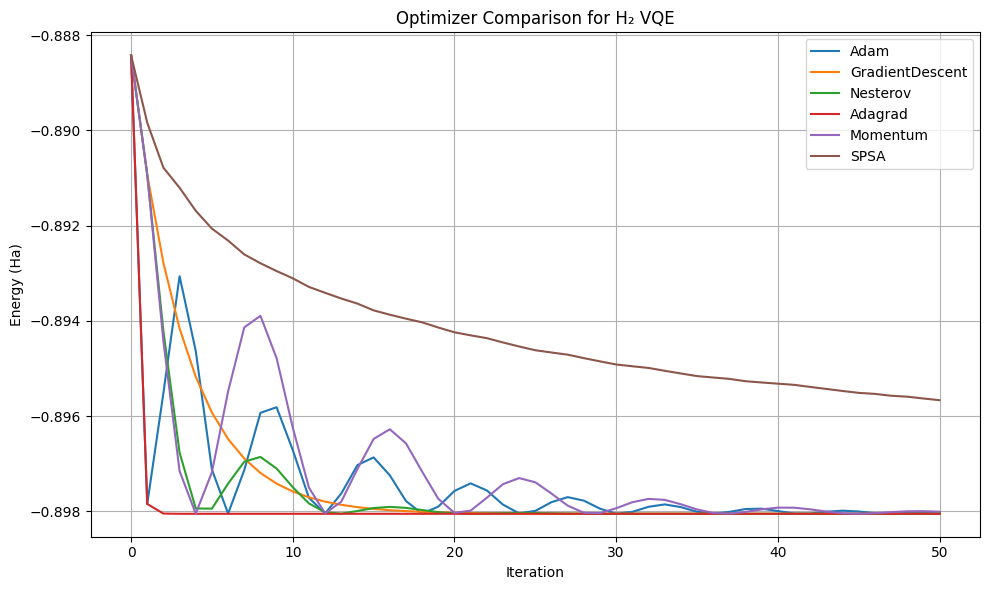

In [10]:
# Plot comparison of all optimizer energy curves
plt.figure(figsize=(10, 6))

for name, res in results.items():
    energies = res["energy"]
    plt.plot(range(len(energies)), energies, label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("Optimizer Comparison for H₂ VQE")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save it to the images directory
os.makedirs("images", exist_ok=True)
plt.savefig("images/H2_Optimiser_Comparison.png")
plt.show()

In [11]:
for name, res in results.items():
    final_energy = res["energy"][-1]
    print(f"{name}:\nFinal ground state energy = {final_energy:.8f} Ha\n")

Adam:
Final ground state energy = -0.89801978 Ha

GradientDescent:
Final ground state energy = -0.89805304 Ha

Nesterov:
Final ground state energy = -0.89805302 Ha

Adagrad:
Final ground state energy = -0.89805304 Ha

Momentum:
Final ground state energy = -0.89801009 Ha

SPSA:
Final ground state energy = -0.89566722 Ha



In [16]:
# Choose optimizer with lowest final energy
best_params = results[best_name]["params"]
print(f"Using best optimizer: {best_name}")

num_singles = len(singles)
num_doubles = len(doubles)

best_thetas_s = best_params[:num_singles]
best_thetas_d = best_params[num_singles:]


@qml.qnode(dev)
def ground_state(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf,
                      excitations=(singles, doubles), excitation_type="both")
    
    # Return the entire quantum statevector
    return qml.state()

final_state = ground_state(best_params)

# Find non-zero (or near non-zero) entries
threshold = 1e-2  # Recommended smaller threshold to capture all significant amplitudes
non_zero_indices = np.where(np.abs(final_state) > threshold)[0]
non_zero_amplitudes = final_state[non_zero_indices]

# Build the full ket notation string
ket_terms = []
for idx, amp in zip(non_zero_indices, non_zero_amplitudes):
    binary_state = f"|{idx:0{num_wires}b}>"
    
    # Format the amplitude nicely
    amp_str = f"{amp.real:.4f}" if np.isclose(amp.imag, 0, atol=1e-6) else f"({amp.real:.4f} + {amp.imag:.4f}j)"
    ket_terms.append(f"{amp_str}{binary_state}")

# Join all terms into one quantum state expression and print
ket_notation = " + ".join(ket_terms)
print(f"Ground state of H₂:\n|ψ⟩ = {ket_notation}")

Using best optimizer: Adagrad
Ground state of H₂:
|ψ⟩ = -0.0585|0011> + 0.9983|1100>


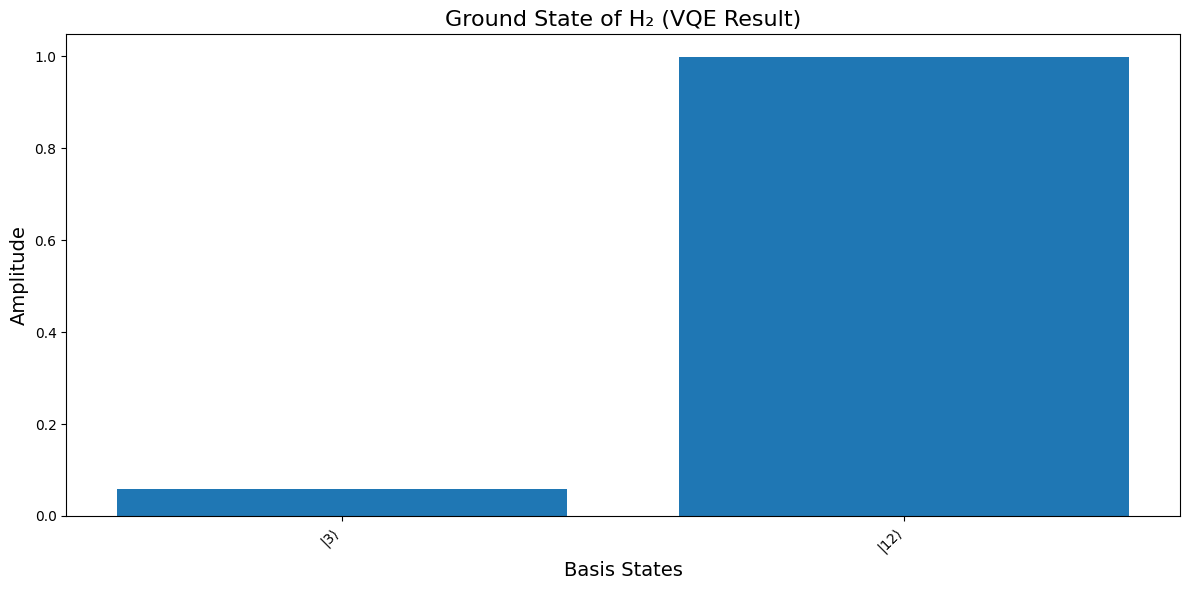

In [17]:
# Prepare labels and amplitudes for the plot
labels = [f"|{idx}⟩" for idx in non_zero_indices]  # No extra brackets

amplitudes = np.abs(non_zero_amplitudes)

# Bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, amplitudes)
plt.xlabel('Basis States', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Ground State of H₂ (VQE Result)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figure to the "images" directory
plt.savefig('images/H2_Ground_State.png')
plt.show()